# $P \rightarrow \nu K$

## Efficiency estimates
Simple calculation. Signal consists of Kaon deposited energy

### Requirements
1. Kaon spectrum
2. Kaon Quenching

### Todo
Building a toy MC
- [ ] Setup assumptions on photocoverage / collection efficiency
- [ ] Extract emission spectrum from ratdb

In [1]:
# Assumptions
coverage = 0.90
effeciency = 0.35 #HQE?

0.35

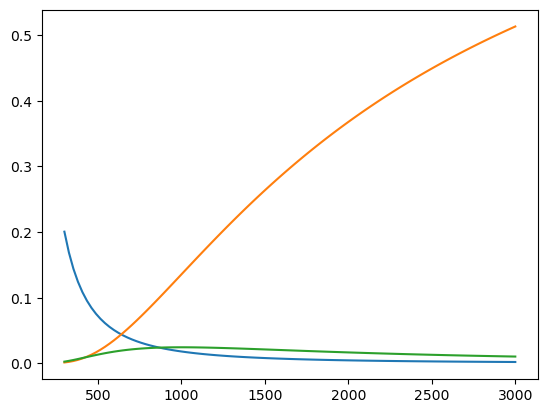

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8a37c2d710>

In [111]:
# Test cherenkov
using PyPlot
ep = ℯ

function cherenkov_frequency(f)
    L = 1
    a = 1/137
    s = (1 - (3/4)^2)
    c = 3e8
    nm = 1e-9
    return 2*π*a*L*s./(nm*f).^2*c^2
end

function extinction(f, l)
    nm = 5e-4
    co = (nm*f).^-1
    return ep.^(-co)
end

w = range(300, 3000; length=101)

plot(w, cherenkov_frequency(w)./1e29)
show()

plot(w, extinction(w, 1))
show()

J = cherenkov_frequency(w)./1e29 .* extinction(w, 1) * 10
plot(w, J)

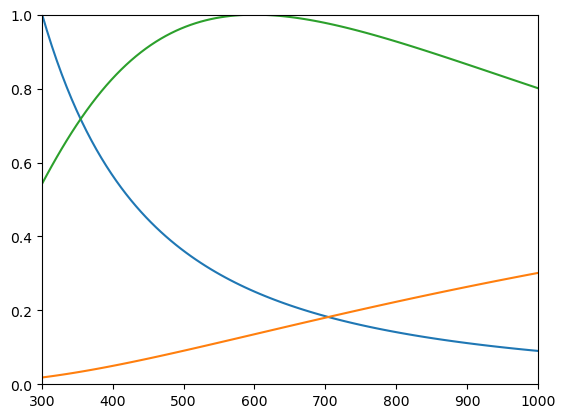

In [169]:
# Test cherenkov
using PyPlot
ep = ℯ

function cherenkov_frequency(f)
    L = 1
    a = 1/137
    s = (1 - (3/4)^2)
    c = 3e8
    nm = 1e-9
    return 2*π*a*L*s./(nm*f).^2*c^2
end

function extinction(f, l)
    nm = 1e-2
    co = (nm*f).^-1
    return ep.^(-co*l)
end

w = range(300, 1000; length=101)

L = 12 # meters?
radiation = cherenkov_frequency(w)./2e28
rayleigh = extinction(w, L)

plot(w, radiation)
plot(w, rayleigh)

J = radiation .* rayleigh
J /= maximum(J)
plot(w, J)
ylim(0, 1)
xlim(300, 1000)
show()

In [70]:
using Printf
using SpecialFunctions

function ckresults(;
        concentration=0.1,
        coverage=0.9,
        QE=0.35,
        Qk=0.5,
        scint_contam = 0.10,
        Qmu=0.5
    )
    cherenkov = coverage * QE * 100
    scintillation = coverage * QE * 10000 * concentration
    k_ke = 105
    mu_ke = 152
    bkg_ke = k_ke + mu_ke
    # Estimate on binning
    scint_loss = 0.50
    cher_loss = 2/3 # mistagged
    scint_contam = scint_contam * scint_loss
    
    true_c  = 1 - cher_loss
    false_c = cher_loss * scint_loss
    true_s = 1 - scint_loss
    false_s = scint_contam
    
    # Photons per MeV
    sc = cherenkov*true_c*(mu_ke-55) + scintillation*false_s*(Qk*k_ke + Qmu*mu_ke)
    ss = cherenkov*false_c*(mu_ke-55) + scintillation*true_s*(Qk*k_ke + Qmu*mu_ke)
    signal_cs = sc/ss

    bc = cherenkov*true_c*(bkg_ke-55) + scintillation*false_s*(Qmu*bkg_ke)
    bs = cherenkov*false_c*(bkg_ke-55) + scintillation*true_s*(Qmu*bkg_ke)
    bkg_cs = bc/bs
    sig_err = signal_cs*(1/sc + 1/ss)^0.5
    bkg_err = bkg_cs*(1/bc+1/bs)^0.5
    @printf("Signal R: %0.4f +- %0.4f\n",signal_cs, sig_err)
    @printf("Bkg R: %0.4f +- %0.4f\n",bkg_cs, bkg_err)
    # 4 sigma cut
    cut_at = signal_cs + sig_err*4
    rejection = (bkg_cs - cut_at)/bkg_err
    rejection = erf(rejection/2^0.5)
    @printf("Cutting at %0.4f provides a %0.4f bkg rejection\n", cut_at, rejection)
    println("Introducing systematics")
    Qk = Qk*0.5
    sc_s = cherenkov*true_c*(mu_ke-55) + scintillation*false_s*(Qk*k_ke + Qmu*mu_ke)
    ss_s = cherenkov*false_c*(mu_ke-55) + scintillation*true_s*(Qk*k_ke + Qmu*mu_ke)
    signal_cs_s = sc_s/ss_s
    @printf("New sig R: %0.4f\n", signal_cs_s)
    sig_err = signal_cs_s - signal_cs
    @printf("Signal R: %0.4f +- %0.4f\n",signal_cs, sig_err)
    @printf("Bkg R: %0.4f +- %0.4f\n",bkg_cs, bkg_err)
    cut_at = signal_cs + sig_err*2
    rejection = (bkg_cs - cut_at)/bkg_err
    rejection = erf(rejection/2^0.5)
    @printf("Cutting at %0.4f provides a %0.4f bkg rejection\n", cut_at, rejection)
end

ckresults()
println("\n")
ckresults(;scint_contam=0.5)

Signal R: 0.1431 +- 0.0028
Bkg R: 0.1854 +- 0.0031
Cutting at 0.1542 provides a 1.0000 bkg rejection
Introducing systematics
New sig R: 0.1535
Signal R: 0.1431 +- 0.0104
Bkg R: 0.1854 +- 0.0031
Cutting at 0.1639 provides a 1.0000 bkg rejection


Signal R: 0.5240 +- 0.0061
Bkg R: 0.5474 +- 0.0062
Cutting at 0.5485 provides a -0.1346 bkg rejection
Introducing systematics
New sig R: 0.5297
Signal R: 0.5240 +- 0.0058
Bkg R: 0.5474 +- 0.0062
Cutting at 0.5355 provides a 0.9469 bkg rejection
